In [25]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from typing import cast

from stochastic_volatility_models.src.core.underlying import Underlying
from stochastic_volatility_models.src.core.volatility_surface import VolatilitySurface
from stochastic_volatility_models.src.core.pricing_models import PricingModel
from stochastic_volatility_models.src.models.heston.heston import HestonModel  # , analytic_prices
from stochastic_volatility_models.src.models.heston.simulation import simulate
from stochastic_volatility_models.visualisations.volatility_surface import plot_volatility_surface
from stochastic_volatility_models.src.utils.options.strikes import find_closest_strikes
from stochastic_volatility_models.src.utils.options.expiry import time_to_expiry

In [26]:
# from scipy.integrate import quad

# spot = 1
# strikes = np.array([1.0766, 1.0766])  # 0.119047619047619
# types = np.array(["C", "P"])
# time_to_expiries = np.array([1.42857142857143, 1.42857142857143])  # 0.9371
# risk_free_rates = np.array([0.02, 0.02])
# dividend_yields = np.array([0, 0])
# parameters = {
# 	"mean_reversion_rate": 3.0,
# 	"initial_variance": 0.08,
# 	"long_term_variance": 0.1,
# 	"volatility_of_volatility": 0.25,
# 	"wiener_correlation": -0.8,
# }


# def test(
# 	spot: float = spot,
# 	strike: float = strikes[0],
# 	time_to_expiry: float = time_to_expiries[0],
# 	risk_free_rate: float = risk_free_rates[0],
# 	dividend_yield: float = dividend_yields[0],
# 	initial_variance: float = parameters["initial_variance"],
# 	long_term_variance: float = parameters["long_term_variance"],
# 	volatility_of_volatility: float = parameters["volatility_of_volatility"],
# 	mean_reversion_rate: float = parameters["mean_reversion_rate"],
# 	wiener_correlation: float = parameters["wiener_correlation"],
# 	lg: int = 64,
# 	debug: bool = False,
# ) -> None:
# 	def characteristic_function(
# 		u,
# 	):
# 		F = spot * np.exp((risk_free_rate - dividend_yield) * time_to_expiry)
# 		xi = mean_reversion_rate - volatility_of_volatility * wiener_correlation * 1j * u
# 		d = np.sqrt(xi**2 + (u**2 + 1j * u) * volatility_of_volatility**2)
# 		A1 = (u**2 + u * 1j) * np.sinh(d * time_to_expiry / 2)
# 		A2 = (d * np.cosh(d * time_to_expiry / 2) + xi * np.sinh(d * time_to_expiry / 2)) / initial_variance
# 		A = A1 / A2
# 		D = np.log(d / initial_variance) + (mean_reversion_rate - d) * time_to_expiry / 2 - np.log(((d + xi) + (d - xi) * np.exp(-d * time_to_expiry)) / (2 * initial_variance))
# 		if isinstance(u, np.ndarray) and debug:
# 			# print("test1", u[-3:])
# 			print("test1.5", np.argwhere(np.isinf((d * time_to_expiry / 2))))
# 			print("test2", np.argwhere(np.isinf(np.sinh(d * time_to_expiry / 2))))
# 			# print("test3", (d * time_to_expiry / 2)[-3:])
# 			# print("test4", np.sinh(d * time_to_expiry / 2)[-3:])
# 			print("A1", np.argwhere(np.isnan(A1)))
# 			print("A2", np.argwhere(np.isnan(A2)))
# 			print("D", np.argwhere(np.isnan(D)))
# 			print("D_inf", np.argwhere(np.isinf(D)))
# 		value = np.exp(1j * u * np.log(F / spot) - mean_reversion_rate * long_term_variance * wiener_correlation * time_to_expiry * 1j * u / volatility_of_volatility + 2 * mean_reversion_rate * long_term_variance * D / (volatility_of_volatility**2)) * np.exp(-A)

# 		return value

# 	def integrand_p1(
# 		u,
# 	):
# 		return np.real(
# 			(np.exp(-1j * u * np.log(strike / spot)) / (u * 1j))
# 			* (
# 				characteristic_function(
# 					u=u - 1j,
# 				)
# 				/ characteristic_function(
# 					u=-1j,
# 				)
# 			)
# 		)

# 	def integrand_p2(
# 		u,
# 	):
# 		return np.real(
# 			(np.exp(-1j * u * np.log(strike / spot)) / (u * 1j))
# 			* characteristic_function(
# 				u=u,  # type: ignore
# 			)
# 		)

# 	def transformed_integrand(x, integrand):
# 		return 2 * integrand((1 + x) / (1 - x)) / ((1 - x) ** 2)

# 	def transformed_integrand_2(x, integrand):
# 		return integrand(1 - 2 * np.exp(-x)) / (1 - x)

# 	transformed_integrand_p1 = lambda x: transformed_integrand(x, integrand_p1)
# 	transformed_integrand_p1_2 = lambda x: transformed_integrand_2(x, integrand_p1)
# 	transformed_integrand_p2 = lambda x: transformed_integrand(x, integrand_p2)
# 	transformed_integrand_p2_2 = lambda x: transformed_integrand_2(x, integrand_p2)

# 	nodes, weights = np.polynomial.legendre.leggauss(deg=lg)

# 	def u(x):
# 		return (1 + x) / (1 - x)

# 	u_nodes = u(nodes)
# 	cf = characteristic_function(
# 		u=u_nodes,
# 	)
# 	# if debug:
# 	# 	print("n",nodes[-3:])
# 	# 	print("w",weights[-3:])
# 	# 	print("un",u_nodes[-3:])
# 	# 	print("cf",cf[-3:])

# 	print("=" * 100)
# 	frac = 0.9
# 	slices = slice(None, int(frac * lg))
# 	linspace = np.linspace(-1, 1, 10000)[1:-1]
# 	# plt.plot(nodes[slices], integrand_p1_values[slices])
# 	# plt.show()
# 	# plt.plot(nodes, nodes, color="green", marker="x")
# 	# plt.plot(linspace, 1+linspace, color="cyan", marker="x", alpha=0.2)
# 	# plt.show()
# 	plt.plot(nodes, transformed_integrand_p1(nodes), color="red")
# 	plt.show()
# 	plt.plot(linspace, transformed_integrand_p1(linspace), color="blue")
# 	plt.show()
# 	# plt.plot(nodes[slices], integrand_p2_values[slices])
# 	# plt.show()
# 	plt.plot(nodes, transformed_integrand_p2(nodes), color="red")
# 	plt.show()
# 	plt.plot(linspace, transformed_integrand_p2(linspace), color="blue")
# 	plt.show()

# 	print("=" * 100)
# 	print(
# 		"LG",
# 		np.sum(weights * transformed_integrand_p1(nodes)),
# 		np.sum(weights * transformed_integrand_p2(nodes)),
# 	)
# 	print(
# 		"Quad",
# 		quad(transformed_integrand_p1, -1, 1)[0],
# 		quad(transformed_integrand_p2, -1, 1)[0],
# 	)
# 	print("=" * 100)
# 	t = nodes[-1]
# 	ut = u(t)
# 	print(u(nodes[-3:]))
# 	print(characteristic_function(t - 1j))
# 	print(characteristic_function(t))
# 	print(characteristic_function(-1j))
# 	print(characteristic_function(-1j))
# 	print(integrand_p1(t))
# 	print(integrand_p1(u(t)))
# 	print(transformed_integrand_p1(t))
# 	print(transformed_integrand_p2(t))
# 	F = spot * np.exp((risk_free_rate - dividend_yield) * time_to_expiry)
# 	xi = mean_reversion_rate - volatility_of_volatility * wiener_correlation * 1j * ut
# 	d = np.sqrt(xi**2 + (ut**2 + 1j * ut) * volatility_of_volatility**2)
# 	A1 = (ut**2 + ut * 1j) * np.sinh(d * time_to_expiry / 2)
# 	A2 = (d * np.cosh(d * time_to_expiry / 2) + xi * np.sinh(d * time_to_expiry / 2)) / initial_variance
# 	A = A1 / A2
# 	D = np.log(d / initial_variance) + (mean_reversion_rate - d) * time_to_expiry / 2 - np.log(((d + xi) + (d - xi) * np.exp(-d * time_to_expiry)) / (2 * initial_variance))
# 	value = np.exp(1j * ut * np.log(F / spot) - mean_reversion_rate * long_term_variance * wiener_correlation * time_to_expiry * 1j * ut / volatility_of_volatility + 2 * mean_reversion_rate * long_term_variance * D / (volatility_of_volatility**2)) * np.exp(-A)
# 	print((ut**2 + ut * 1j) * np.sinh(d * time_to_expiry / 2) / ((d * np.cosh(d * time_to_expiry / 2) + xi * np.sinh(d * time_to_expiry / 2)) / initial_variance))
# 	print("", xi, d, A1, A2, A, D, value, sep="\n::")
# 	print("cf", characteristic_function(ut))
# 	print("cfm", characteristic_function(ut - 1j))
# 	print("ex", (np.exp(-1j * ut * np.log(strike / spot)) / (ut * 1j)))
# 	print("ex2", np.real((np.exp(-1j * ut * np.log(strike / spot)) / (ut * 1j)) * characteristic_function(ut) / characteristic_function(-1j)))
# 	print(np.argwhere(np.isnan(transformed_integrand_p1(nodes))))
# 	print(np.argwhere(np.isnan(np.array([transformed_integrand_p1(node) for node in nodes]))))
# 	print(nodes[-1])
# 	print(transformed_integrand_p1(nodes[-1]))
# 	print([transformed_integrand_p1(node) for node in nodes[-2:]])


# test(
# 	risk_free_rate=0,
# 	time_to_expiry=0.000,
# 	strike=0.000001,
# 	lg=256,
# 	debug=False,
# )


In [27]:
# import numexpr as ne


# def cos_restriction(self):
# 	lm, mu, eta = self.param.lm, self.param.mu, self.param.eta
# 	rho, sigma = self.param.rho, self.param.sigma

# 	L = 12
# 	c1 = self.riskfree * self.maturity + (1 - np.exp(-lm * self.maturity)) * (mu - sigma) / 2 / lm - mu * self.maturity / 2

# 	c2 = (
# 		1
# 		/ (8 * lm**3)
# 		* (
# 			eta * self.maturity * lm * np.exp(-lm * self.maturity) * (sigma - mu) * (8 * lm * rho - 4 * eta)
# 			+ lm * rho * eta * (1 - np.exp(-lm * self.maturity)) * (16 * mu - 8 * sigma)
# 			+ 2 * mu * lm * self.maturity * (-4 * lm * rho * eta + eta**2 + 4 * lm**2)
# 			+ eta**2 * ((mu - 2 * sigma) * np.exp(-2 * lm * self.maturity) + mu * (6 * np.exp(-lm * self.maturity) - 7) + 2 * sigma)
# 			+ 8 * lm**2 * (sigma - mu) * (1 - np.exp(-lm * self.maturity))
# 		)
# 	)

# 	a = c1 - L * np.abs(c2) ** 0.5
# 	b = c1 + L * np.abs(c2) ** 0.5

# 	return a, b


# def cosmethod(model, moneyness=0.0, call=True, npoints=2**10):
# 	alim, blim = model.cos_restriction()
# 	kvec = np.arange(npoints)[:, np.newaxis] * np.pi / (blim - alim)
# 	unit = np.append(0.5, np.ones(npoints - 1))
# 	argc = (kvec, alim, blim, 0, blim)
# 	argp = (kvec, alim, blim, alim, 0)
# 	put = np.logical_not(call)
# 	umat = 2 / (blim - alim) * (call * xfun(*argc) - put * xfun(*argp))
# 	pmat = model.charfun(kvec)
# 	xmat = np.exp(-1j * kvec * (moneyness + alim))
# 	return np.exp(moneyness) * np.dot(unit, pmat * umat * xmat).real


# def xfun(k, a, b, c, d):
# 	out0 = ne.evaluate(("(cos(k * (d-a)) * exp(d) - cos(k * (c-a)) * exp(c)" "+ k * (sin(k * (d-a)) * exp(d) - sin(k * (c-a)) * exp(c)))" "/ (1 + k**2)"))
# 	k1 = k[1:]  # noqa F841
# 	out1 = ne.evaluate("(sin(k1 * (d-a)) - sin(k1 * (c-a))) / k1")

# 	out1 = np.vstack([(d - c) * np.ones_like(a), out1])

# 	return out0 - out1


In [28]:
# def heston_characteristic_function(u, S0, K, r, T, kappa, theta, sigma, rho, v0):
# 	xi = kappa - rho * sigma * 1j * u
# 	d = np.sqrt((rho * sigma * 1j * u - xi) ** 2 - sigma**2 * (-u * 1j - u**2))
# 	g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
# 	C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
# 	D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
# 	return np.exp(C + D * v0 + 1j * u * np.log(S0))


# # Define functions to compute call and put options prices
# def heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
# 	integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
# 	integral, _ = quad(integrand, 0, np.inf)
# 	return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral


# def heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
# 	integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
# 	integral, _ = quad(integrand, 0, np.inf)
# 	return np.exp(-r * T) / np.pi * integral - S0 + K * np.exp(-r * T)


In [29]:
# spot = 1
# t2x = 0
# K = 10
# r = 0
# q = 0
# types = np.array(["C", "P"])
# strikes = np.array([K] * len(types))  # 0.119047619047619
# time_to_expiries = np.array([t2x] * len(types))  # 0.9371
# risk_free_rates = np.array([r] * len(types))
# dividend_yields = np.array([q] * len(types))
# parameters = {
# 	"mean_reversion_rate": 3.0,
# 	"initial_variance": 0.08,
# 	"long_term_variance": 0.1,
# 	"volatility_of_volatility": 0.25,
# 	"wiener_correlation": -0.8,
# }

# prices = analytic_prices(
# 	spot=spot,
# 	types=types,
# 	strikes=strikes,
# 	time_to_expiries=time_to_expiries,
# 	risk_free_rates=risk_free_rates,
# 	dividend_yields=dividend_yields,
# 	**parameters,
# 	legendre_gauss_degree=512,
# )
# print(prices)
# print(
# 	analytic_prices(
# 		spot=spot,
# 		types=types,
# 		strikes=strikes,
# 		time_to_expiries=time_to_expiries,
# 		risk_free_rates=risk_free_rates,
# 		dividend_yields=dividend_yields,
# 		**parameters,
# 		legendre_gauss_degree=None,
# 	)
# )


```python
p1 = {
	'initial_variance': 1.5735434638117027,
	'long_term_variance': -5.585043916635598,
	'volatility_of_volatility': -1.4008118465141628,
	'mean_reversion_rate': 2.7847101214701397,
	'wiener_correlation': -0.8231322657874336
}

p* = {
	'initial_variance': 0.12345958113897741,
	'long_term_variance': 0.03229477520858324,
	'volatility_of_volatility': 0.7082595297644024,
	'mean_reversion_rate': 6.191136702846269,
	'wiener_correlation': -1.0
}
```

In [30]:
ticker = "SPX"
spx = Underlying(ticker)
vix = Underlying("VIX")
pricing_model = PricingModel("Black-76 EMM")
time = np.datetime64("2022-03-03")

In [31]:
expiries = np.array(
	# ["2022-03-04", "2022-03-09", "2022-03-11", "2022-03-18", "2022-03-23", "2022-03-25", "2022-03-30", "2022-03-31", "2022-04-01", "2022-04-08", "2022-04-14", "2022-04-22", "2022-04-29", "2022-05-20", "2022-05-31", "2022-06-17", "2022-06-30", "2022-07-15", "2022-07-29", "2022-08-31"], dtype=np.datetime64
	["2022-03-09", "2022-03-11", "2022-03-18", "2022-03-23", "2022-03-25", "2022-03-30", "2022-03-31", "2022-04-01", "2022-04-08", "2022-04-14", "2022-04-22", "2022-04-29", "2022-05-20", "2022-05-31", "2022-06-17", "2022-06-30", "2022-07-15", "2022-07-29", "2022-08-31"],
	dtype=np.datetime64,
)

strikes = np.array(
	[
		2200,
		2400,
		2600,
		2800,
		3000,
		3200,
		3400,
		3500,
		3600,
		3700,
		3800,
		3850,
		3900,
		3950,
		3975,
		4000,
		4025,
		4040,
		4050,
		4060,
		4070,
		4075,
		4080,
		4090,
		4100,
		4110,
		4120,
		4125,
		4130,
		4140,
		4150,
		4160,
		4170,
		4175,
		4180,
		4190,
		4200,
		4210,
		4220,
		4225,
		4230,
		4240,
		4250,
		4260,
		4270,
		4275,
		4280,
		4290,
		4300,
		4310,
		4320,
		4325,
		4330,
		4340,
		4350,
		4360,
		4370,
		4375,
		4380,
		4390,
		4400,
		4410,
		4420,
		4425,
		4430,
		4440,
		4450,
		4460,
		4470,
		4475,
		4480,
		4490,
		4500,
		4510,
		4525,
		4550,
		4600,
		4650,
		4700,
		4800,
		5000,
		5200,
		5400,
	]
)
spx_vs = VolatilitySurface(
	underlying=spx,
	expiries=expiries,
	strikes=strikes,
	monthly=False,
)

In [32]:
expiries = np.array(["2022-03-09", "2022-03-23", "2022-03-30", "2022-04-06"], dtype=np.datetime64)

strikes = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
vix_vs = VolatilitySurface(
	underlying=vix,
	expiries=expiries,
	strikes=strikes,
	monthly=False,
)

In [33]:
model = HestonModel(parameters={"initial_variance": 0.12345958113897741, "long_term_variance": 0.03229477520858324, "volatility_of_volatility": 0.7082595297644024, "mean_reversion_rate": 6.191136702846269, "wiener_correlation": -1.0})

In [34]:
spx_vs.model_price(time=time, model=model)

,Mid
SPXW 220309C2200000,2163.333107
SPXW 220309P2200000,0.000000
SPXW 220311C2200000,2162.552616
SPXW 220311P2200000,0.000000
SPXW 220318C2200000,2163.371714
...,...
SPXW 220715P5400000,1036.865593
SPXW 220729C5400000,0.544519
SPXW 220729P5400000,1036.827095
SPXW 220831C5400000,1.922397


In [35]:
fig = plot_volatility_surface(
	time=time,
	volatility_surface=spx_vs,
	quantity_method="model_price",
	model=model,
	plot_parameters={"moneyness": False, "time_to_expiry": False, "log_moneyness": False, "mid_price": True},
	out_the_money=True,
)
fig.show()


fig = plot_volatility_surface(
	time=time,
	volatility_surface=spx_vs,
	quantity_method="model_pricing_implied_volatility",
	pricing_model=pricing_model,
	model=model,
	plot_parameters={"moneyness": False, "time_to_expiry": False, "log_moneyness": False, "mid_price": True},
	out_the_money=True,
)
fig.show()

T: 2022-03-09


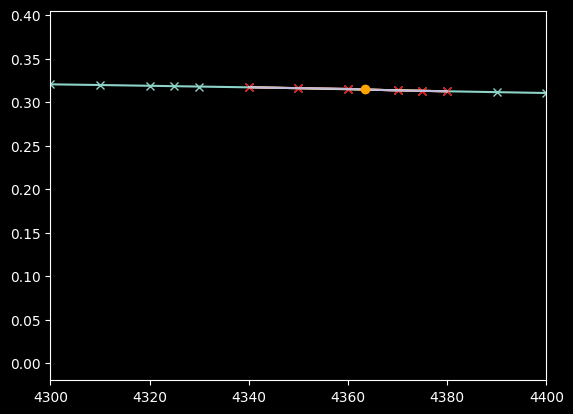

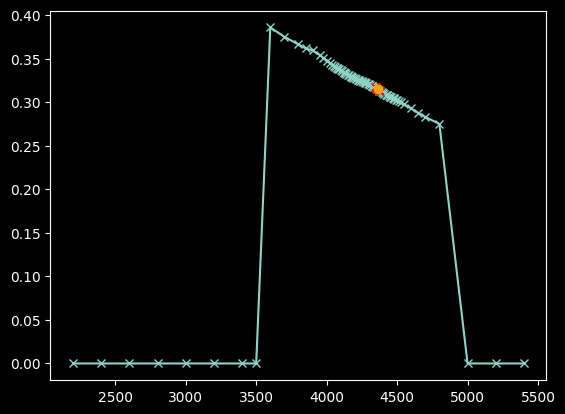

T: 2022-03-11


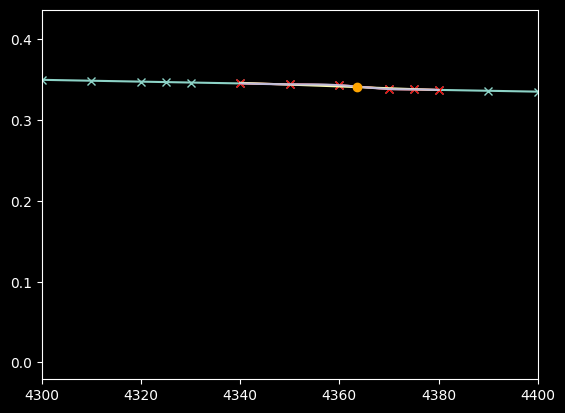

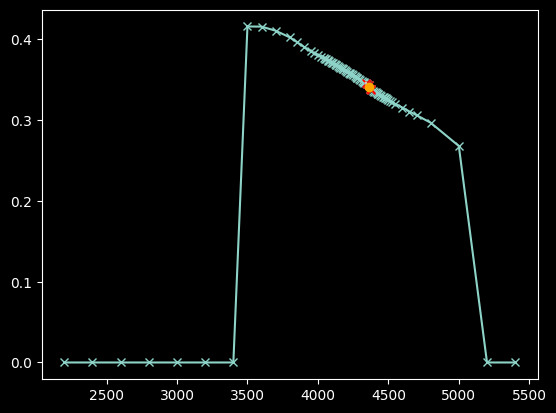

T: 2022-03-18


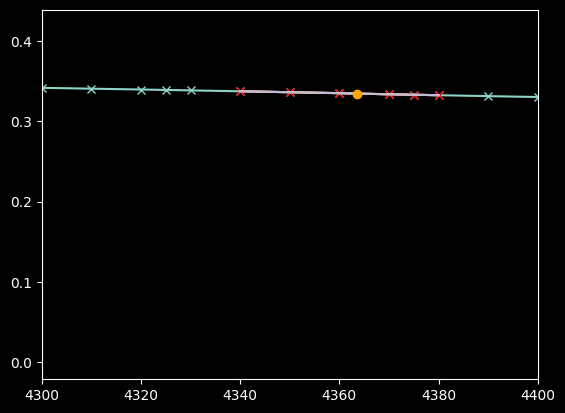

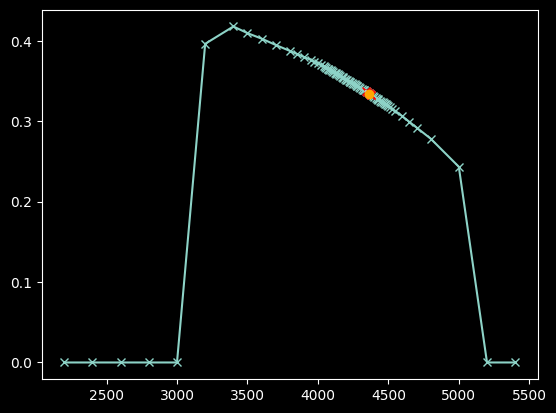

T: 2022-03-23


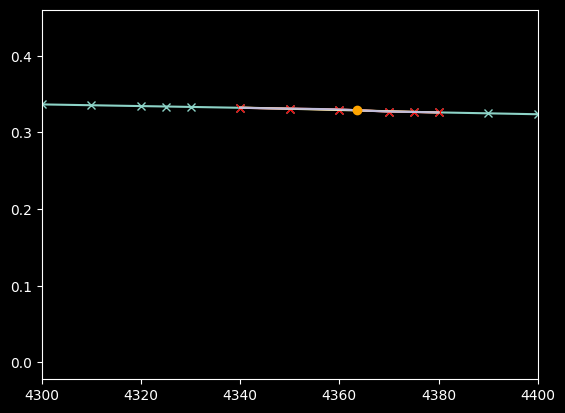

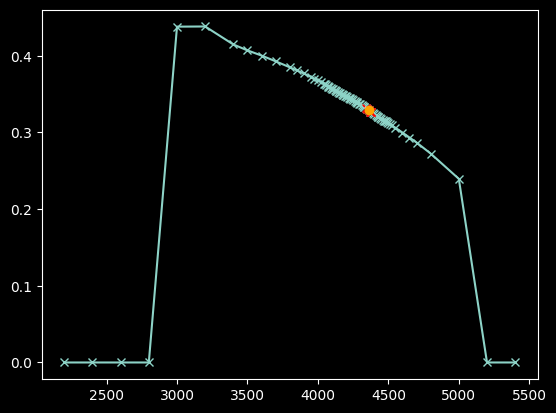

T: 2022-03-25


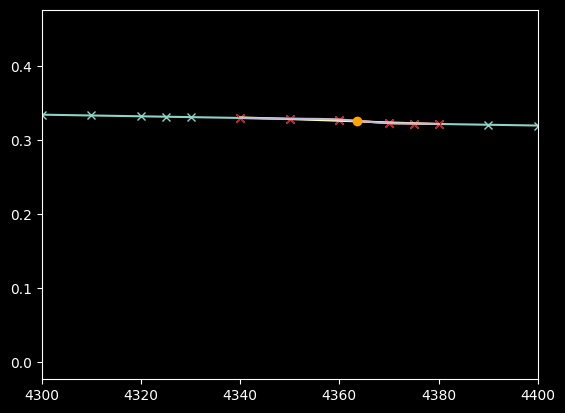

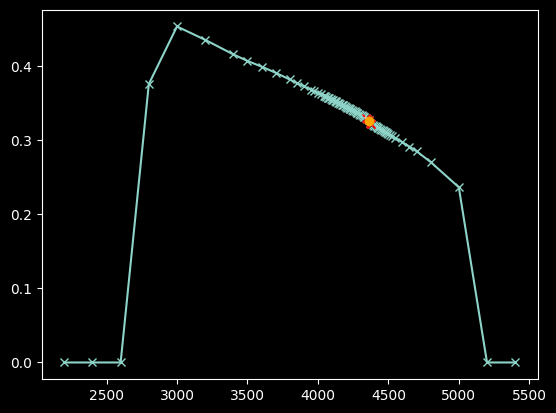

T: 2022-03-30


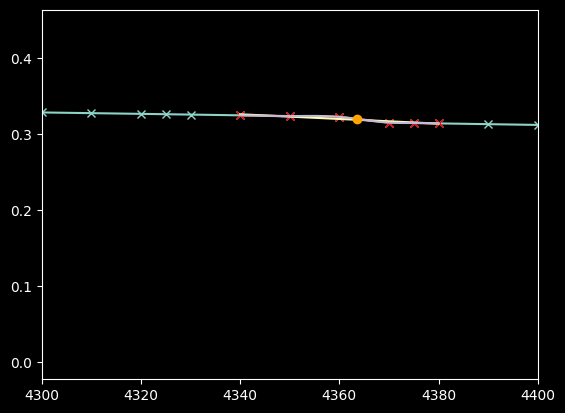

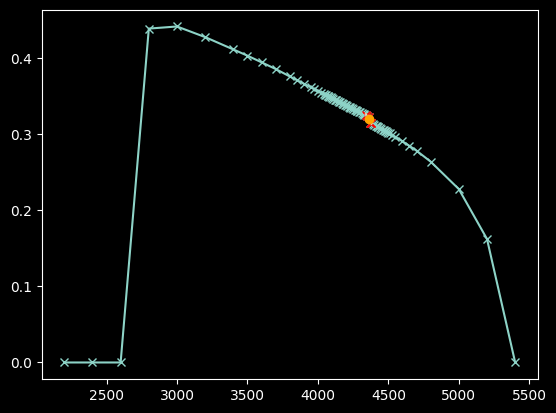

T: 2022-03-31


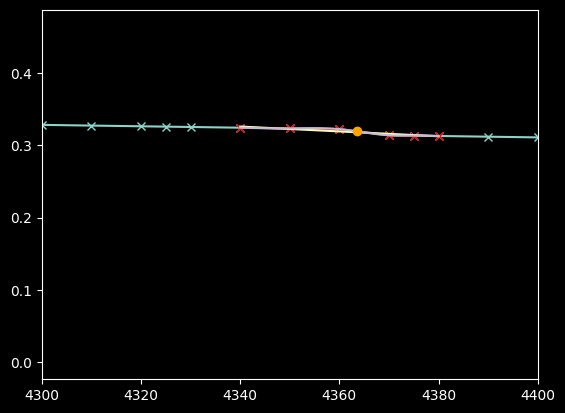

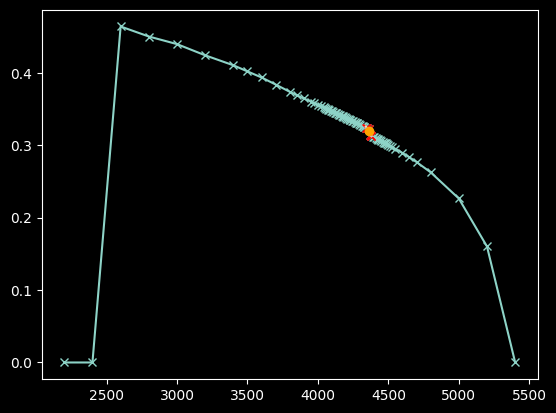

T: 2022-04-01


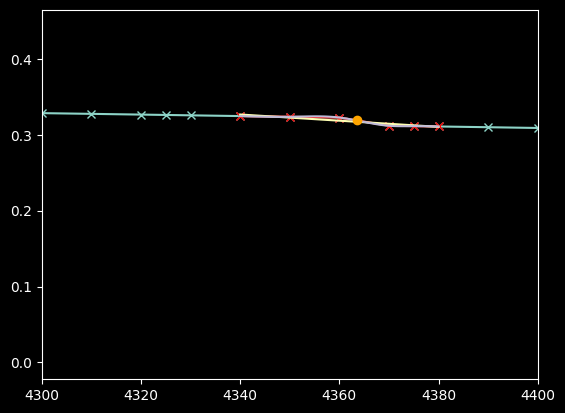

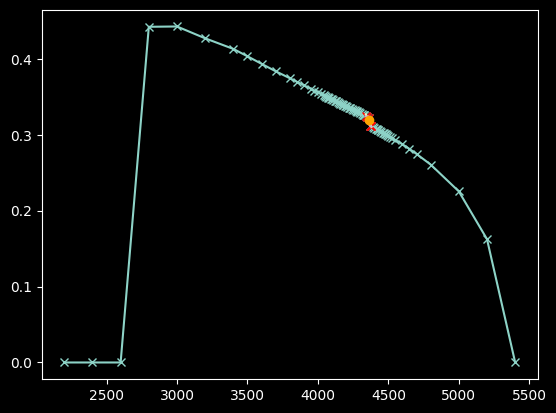

T: 2022-04-08


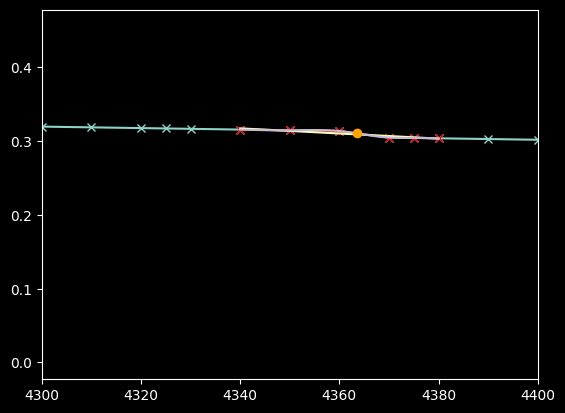

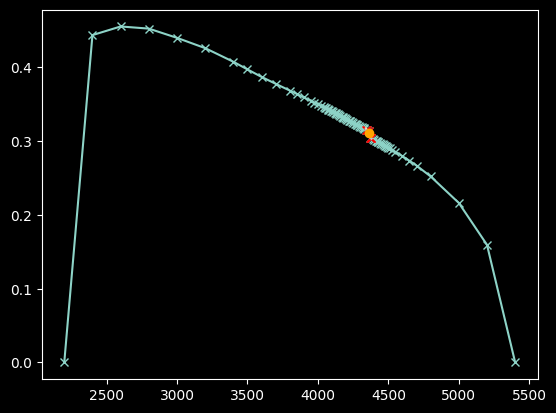

T: 2022-04-14


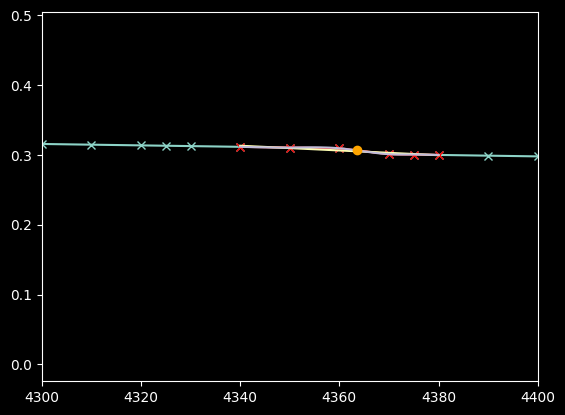

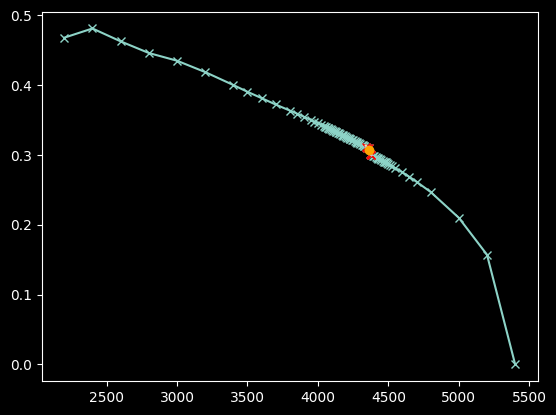

T: 2022-04-22


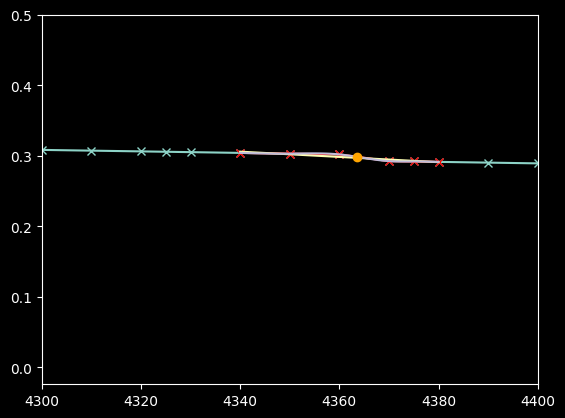

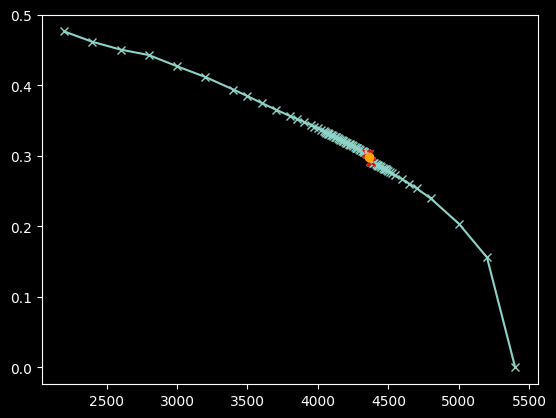

T: 2022-04-29


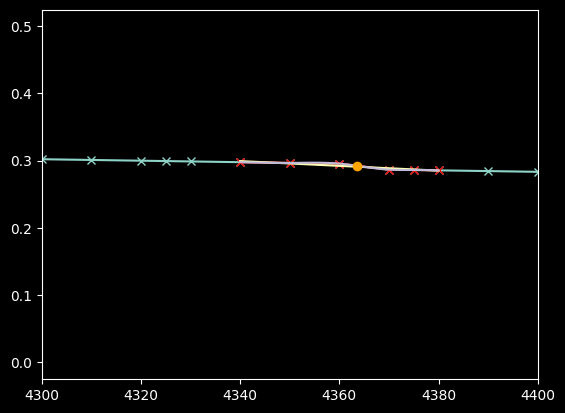

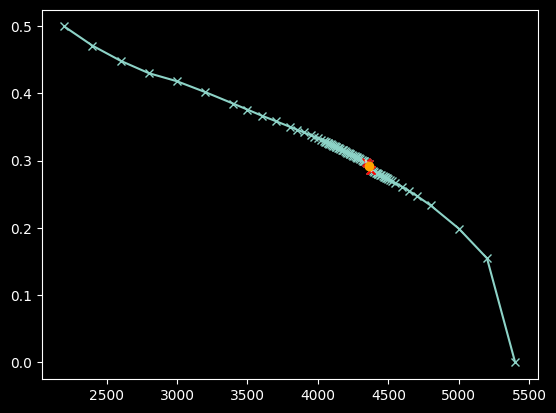

T: 2022-05-20


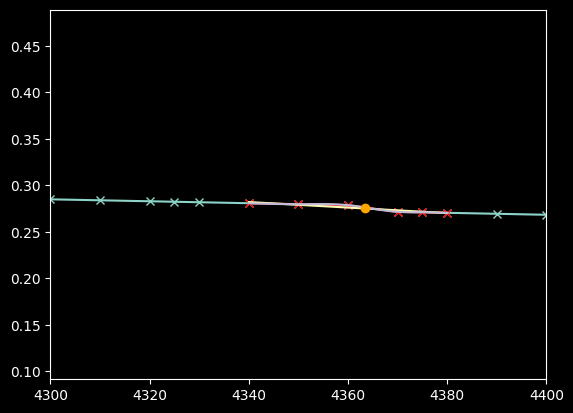

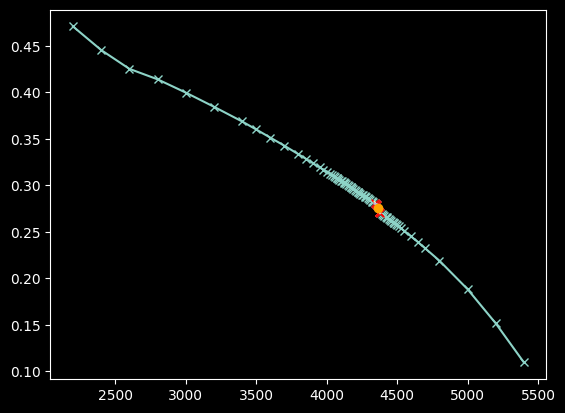

T: 2022-05-31


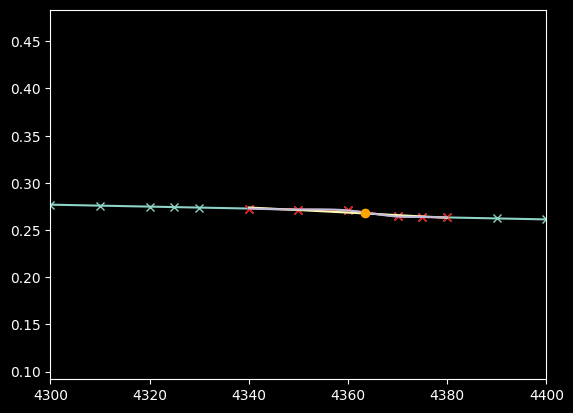

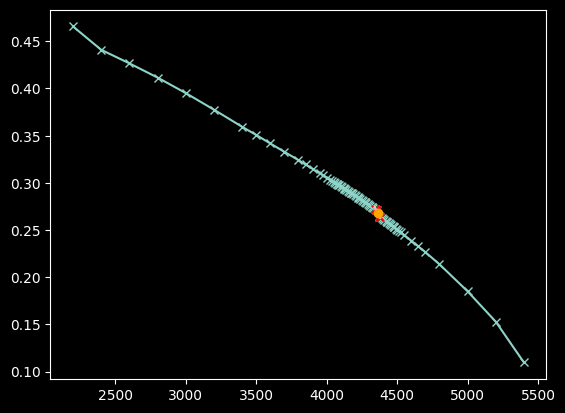

T: 2022-06-17


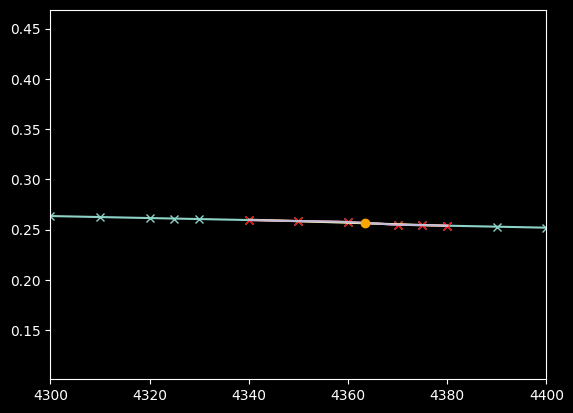

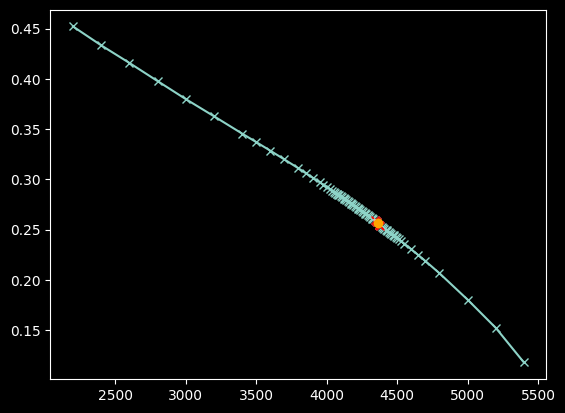

T: 2022-06-30


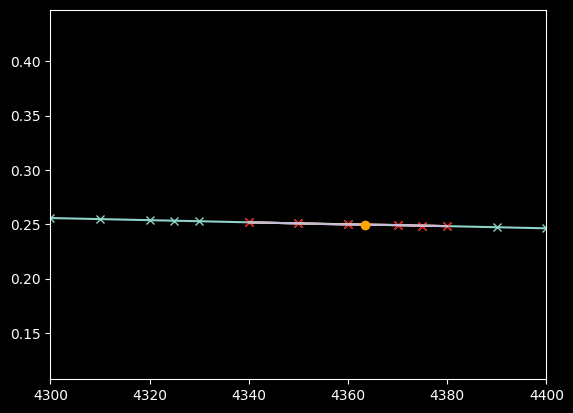

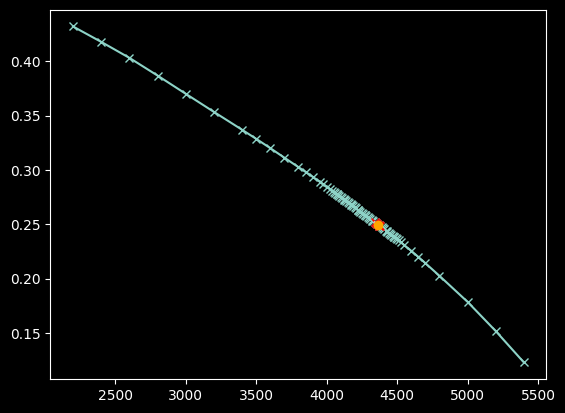

T: 2022-07-15


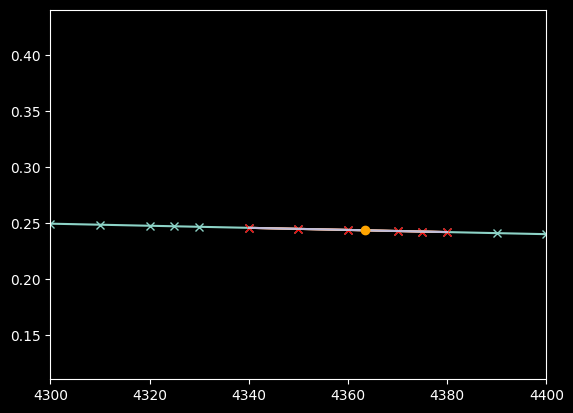

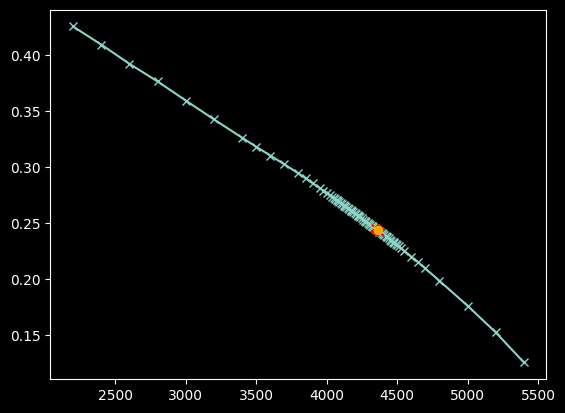

T: 2022-07-29


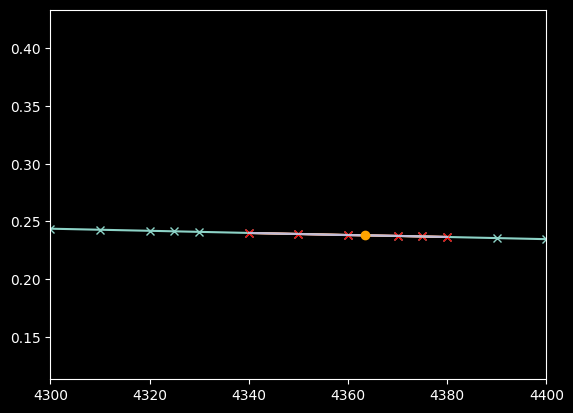

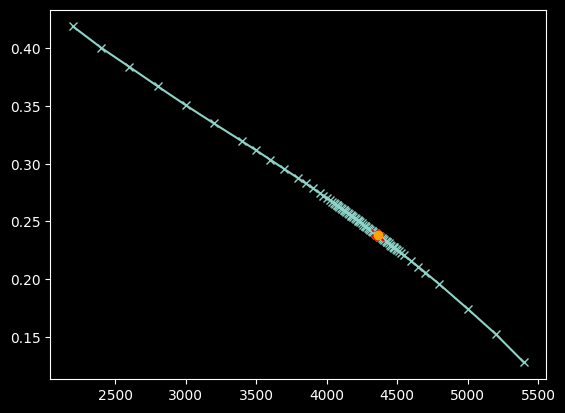

T: 2022-08-31


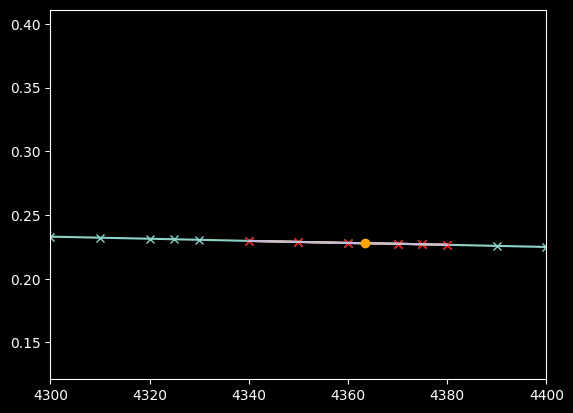

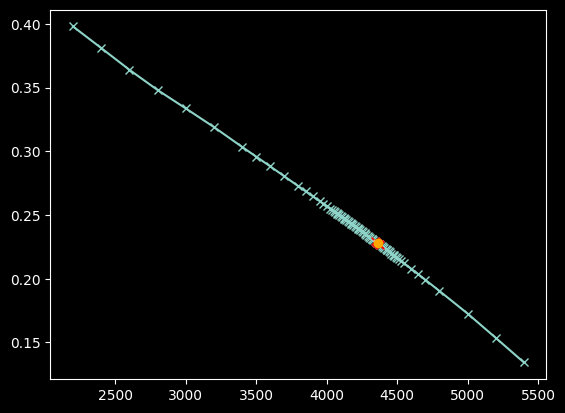

In [36]:
plot_closeup = True

volatility_surface = spx_vs
surface = volatility_surface.surface_quantities(
	time=time,
	quantity_method="model_pricing_implied_volatility",
	price_types=["Mid"],
	out_the_money=True,
	pricing_model=pricing_model,
	model=model,
)[0]
for i, expiry in enumerate(volatility_surface.expiries):
	print(f"T: {expiry}")
	t2x = time_to_expiry(time, volatility_surface.expiries)
	indices = find_closest_strikes(
		strikes=volatility_surface.strikes,
		spot=volatility_surface.underlying.price(time=time),
	)
	# print(indices)
	cs = CubicSpline(
		x=indices,
		y=cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values,
		bc_type="natural",
	)
	x = np.linspace(indices.min(), indices.max(), 100)
	s, i = np.polyfit(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].to_numpy(), 1)

	if plot_closeup:
		plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
		plt.plot(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values, linestyle=None, marker="x", color="red")
		plt.plot(x, s * x + i)
		plt.plot(x, cs(x))
		plt.plot((spot := volatility_surface.underlying.price(time=time)), cs(spot), color="orange", marker="o")
		plt.gca().set_xlim(4300, 4400)
		# plt.gca().set_ylim(0.22, 0.34)
		plt.show()

	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.plot(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values, linestyle=None, marker="x", color="red")
	plt.plot(x, s * x + i)
	plt.plot(x, cs(x))
	plt.plot((spot := volatility_surface.underlying.price(time=time)), cs(spot), color="orange", marker="o")
	plt.show()

T: 2022-03-09


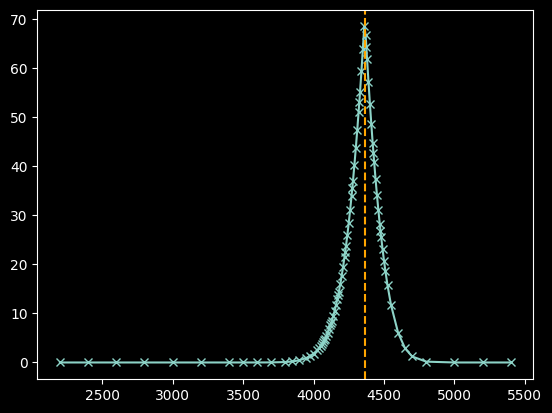

T: 2022-03-11


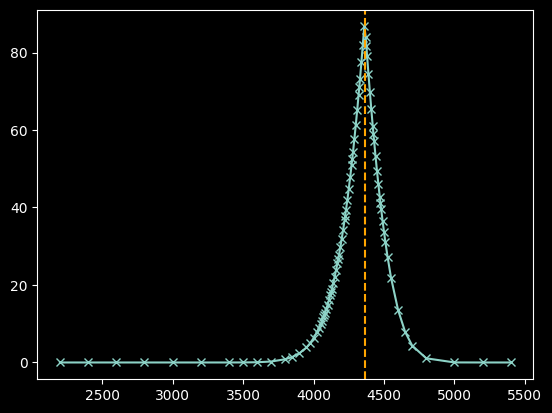

T: 2022-03-18


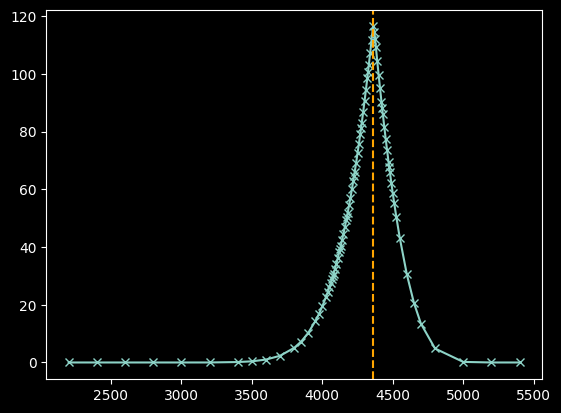

T: 2022-03-23


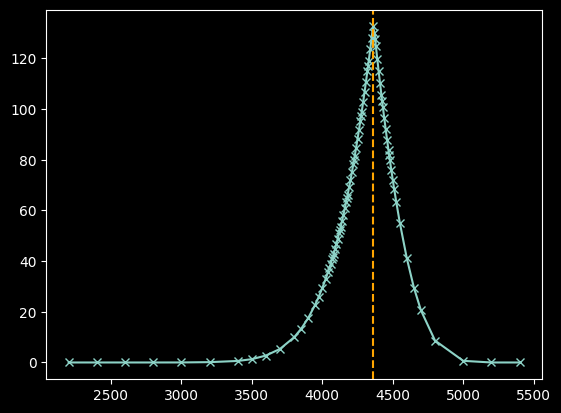

T: 2022-03-25


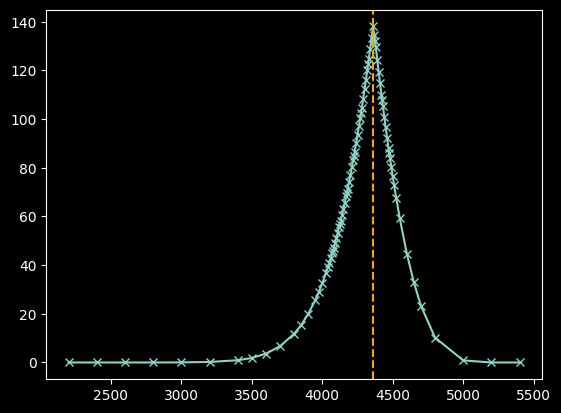

T: 2022-03-30


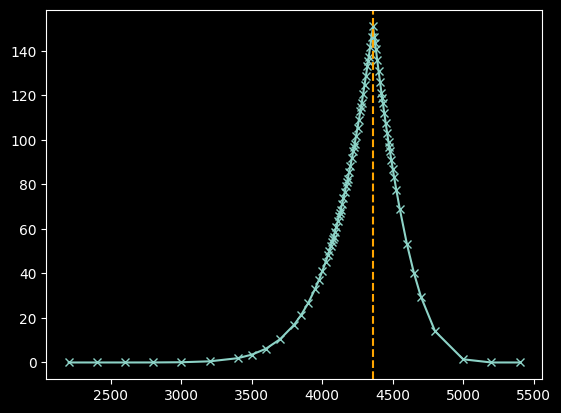

T: 2022-03-31


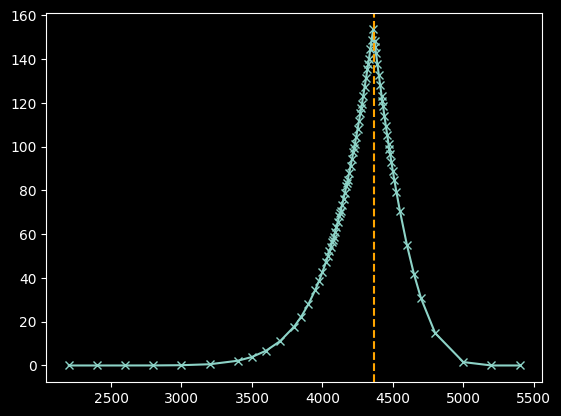

T: 2022-04-01


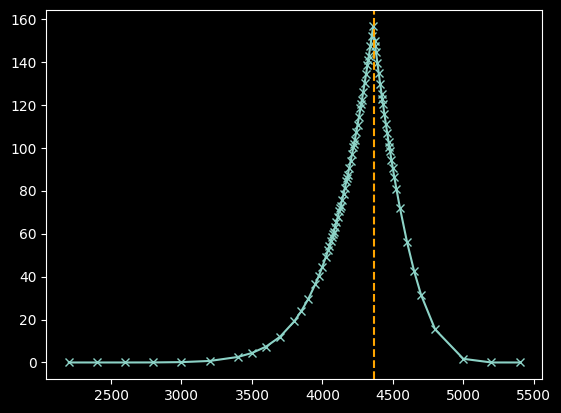

T: 2022-04-08


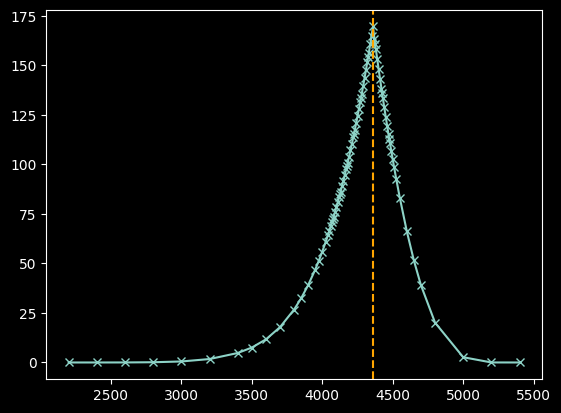

T: 2022-04-14


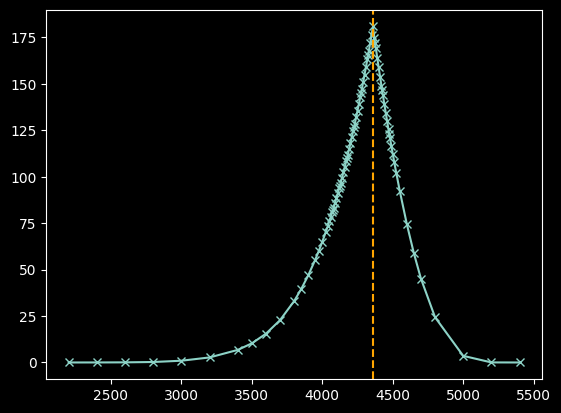

T: 2022-04-22


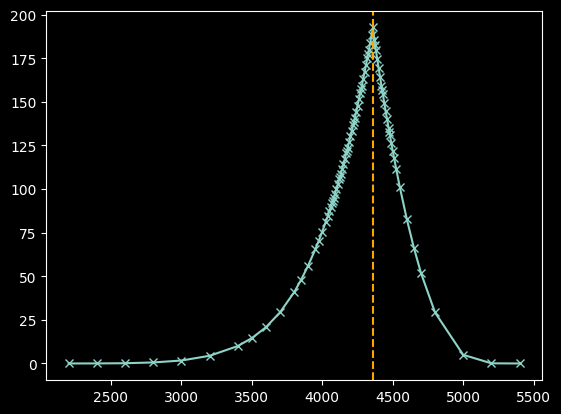

T: 2022-04-29


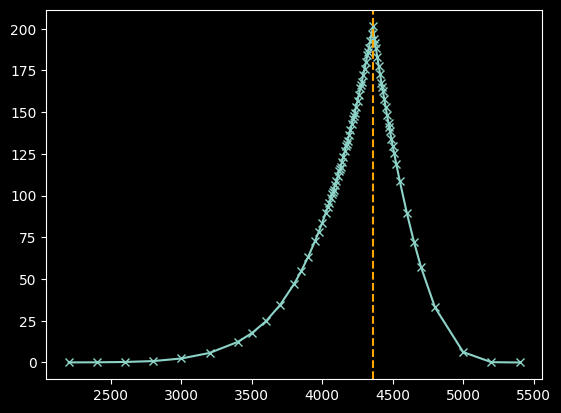

T: 2022-05-20


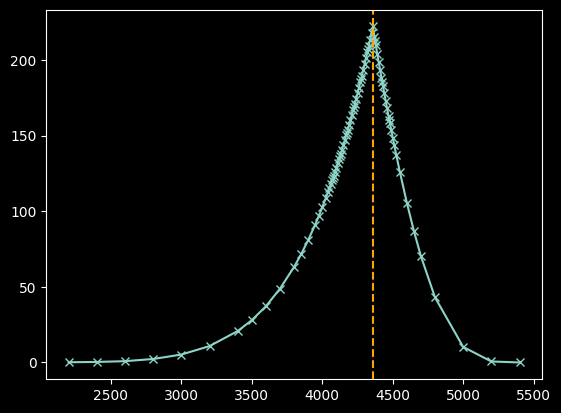

T: 2022-05-31


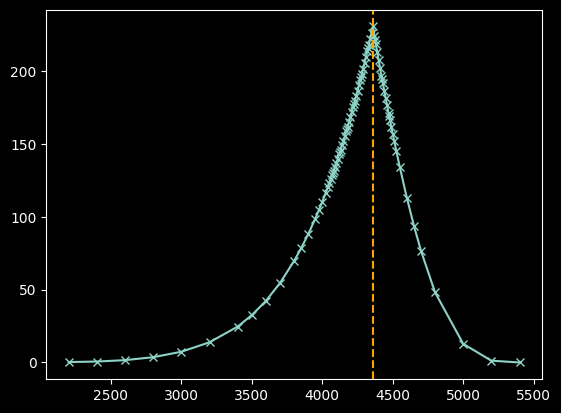

T: 2022-06-17


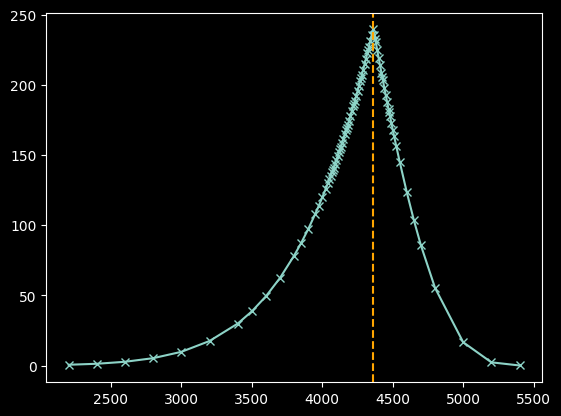

T: 2022-06-30


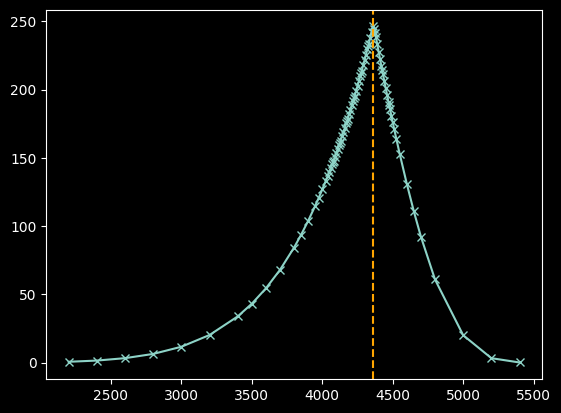

T: 2022-07-15


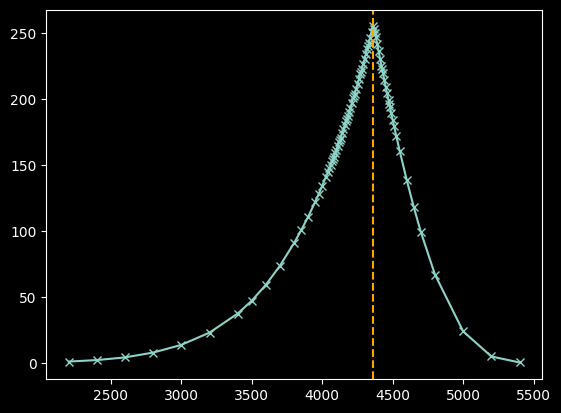

T: 2022-07-29


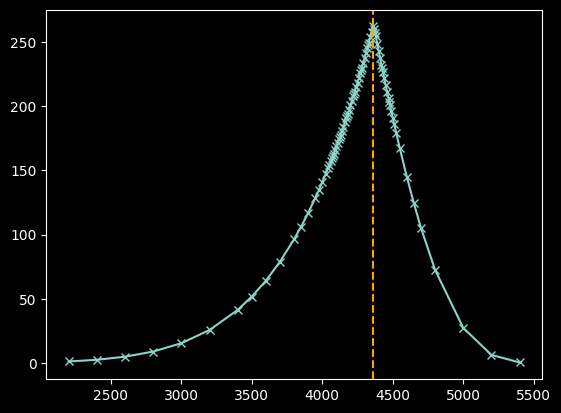

T: 2022-08-31


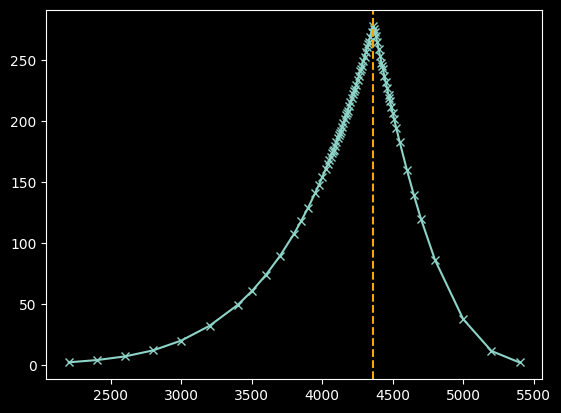

In [37]:
plot_closeup = False

volatility_surface = spx_vs
surface = volatility_surface.surface_quantities(
	time=time,
	quantity_method="model_price",
	price_types=["Mid"],
	out_the_money=True,
	model=model,
)[0]
for i, expiry in enumerate(volatility_surface.expiries):
	print(f"T: {expiry}")
	t2x = time_to_expiry(time, volatility_surface.expiries)
	indices = find_closest_strikes(
		strikes=volatility_surface.strikes,
		spot=volatility_surface.underlying.price(time=time),
	)
	x = np.linspace(indices.min(), indices.max(), 100)
	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.axvline(spot, color="orange", linestyle="dashed")
	plt.show()

In [14]:
parameters = model.fit(
	index_volatility_surface=spx_vs,
	volatility_index_volatility_surface=vix_vs,
	time=time,
	pricing_model=pricing_model,
	weights={
		"volatility_index": 0,
		"skew": 0,
	},
)
print(parameters)

2024-08-09 01:01:05.142 | DEBUG    | stochastic_volatility_models.src.core.calibration:minimise_cost_function:93 - Minimise cost function iteration with parameters {'initial_variance': 0.16, 'long_term_variance': 0.25, 'volatility_of_volatility': 0.8, 'mean_reversion_rate': 6.2, 'wiener_correlation': 0.5}
2024-08-09 01:01:30.015 | DEBUG    | stochastic_volatility_models.src.core.calibration:minimise_cost_function:105 - Cost is 0.2318061921174912
2024-08-09 01:01:30.016 | DEBUG    | stochastic_volatility_models.src.core.calibration:minimise_cost_function:93 - Minimise cost function iteration with parameters {'initial_variance': 0.16000001, 'long_term_variance': 0.25, 'volatility_of_volatility': 0.8, 'mean_reversion_rate': 6.2, 'wiener_correlation': 0.5}
2024-08-09 01:01:30.785 | DEBUG    | stochastic_volatility_models.src.core.calibration:minimise_cost_function:105 - Cost is 0.2318061961339574
2024-08-09 01:01:30.785 | DEBUG    | stochastic_volatility_models.src.core.calibration:minimis

```python
parameters = {
	'initial_variance': 0.12345958113897741,
	'long_term_variance': 0.03229477520858324,
	'volatility_of_volatility': 0.7082595297644024,
	'mean_reversion_rate': 6.191136702846269,
	'wiener_correlation': -1.0
}
```

In [20]:
spot = spx.price(time=time)
strike = 4300
parameters = {"initial_variance": 0.12345958113897741, "long_term_variance": 0.03229477520858324, "volatility_of_volatility": 0.7082595297644024, "mean_reversion_rate": 6.191136702846269, "wiener_correlation": -1.0}

price_process, variance_process = simulate(
	spot=spot,
	ticker="SPX",
	time=time,
	**model.parameters,
	simulation_length=1,
	steps_per_year=252,
	num_paths=2**14,
)

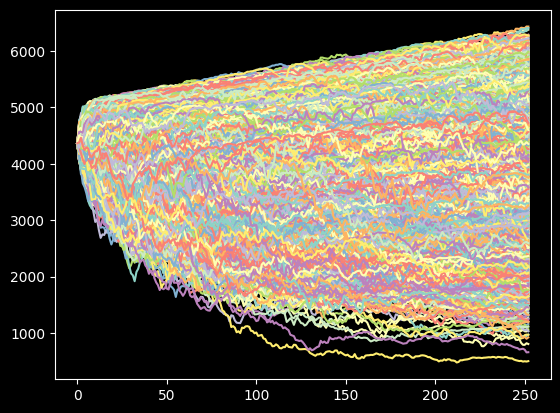

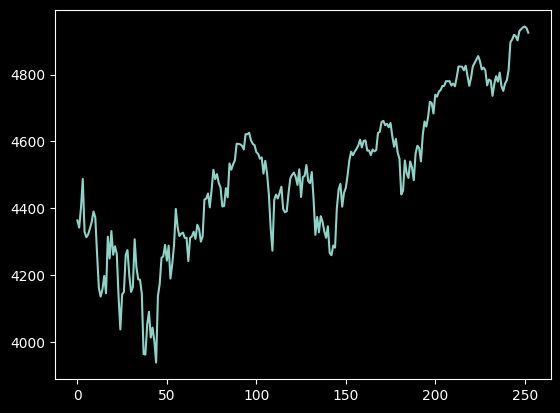

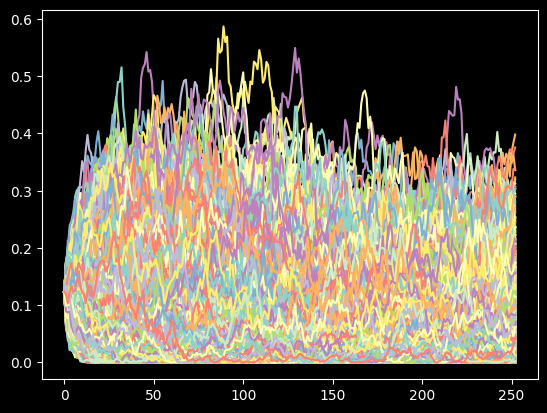

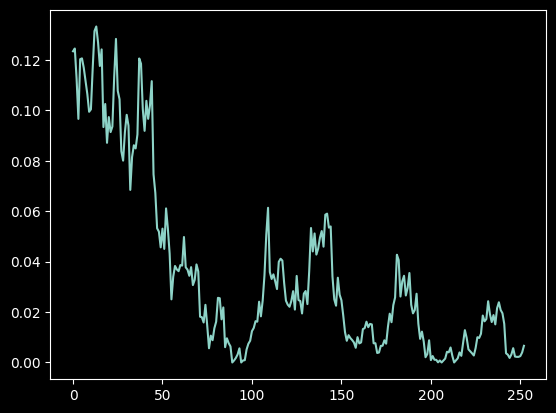

In [39]:
pd.DataFrame(price_process.T).plot(legend=False)
plt.show()

plt.plot(price_process[0])
plt.show()

pd.DataFrame(variance_process.T).plot(legend=False)
plt.show()

plt.plot(variance_process[0])
plt.show()